# Summary

## Yeast

- Number of unique TFs: 162
- Number of TFs with DBDs: 151
- Number of TFs with 9aaTADs: 11
- Total AA length: 101491
- Total DBD length: 17814

Other numbers
- Yeastract: ?? TFs, 118 with characterized DBDs
- UniProt: 174 TFs, 163 in SwissProt

## Human

- Number of unique TFs: 1695
- Number of TFs with DBDs: 1557
- Number of TFs with 9aaTADs: 10
- Total AA length: 1011584
- Total DBD length: 444327

Other numbers
- [Saint-André, Violaine, et al.](https://doi.org/10.1101/gr.197590.115): 1253 TFs
    - Intersection of AnimalTFDB and TcoF minus CTCF, GTF2I and GTF2IRD1

# Definitions and References

Yeast
- Saccharomyces cerevisiae (strain ATCC 204508 / S288c) (Baker's yeast)
- UniProt Taxon ID: 559292

Yeastract
- Papers
    - Hahn, Steven, and Elton T. Young. "Transcriptional regulation in Saccharomyces cerevisiae: transcription factor regulation and function, mechanisms of initiation, and roles of activators and coactivators." *Genetics* 189.3 (2011): 705-736. https://doi.org/10.1534/genetics.111.127019.
        - As of 2011, there were "169 genes designated as TFs in the Yeastract database."
    - Teixeira, Miguel C., et al. "YEASTRACT: an upgraded database for the analysis of transcription regulatory networks in Saccharomyces cerevisiae." Nucleic acids research 46.D1 (2017): D348-D353. https://doi.org/10.1093/nar/gkx842.
        - Latest publication by Yeastract team

Gene Ontology (GO) Terms
- [GO:0003700](https://www.ebi.ac.uk/QuickGO/term/GO:0003700) DNA-binding transcription factor activity
- [GO:0003676](https://www.ebi.ac.uk/QuickGO/term/GO:0003676) nucleic acid binding
- [GO:0003677](https://www.ebi.ac.uk/QuickGO/term/GO:0003677) DNA binding

InterPro
- Entry types: https://www.ebi.ac.uk/interpro/user_manual.html
- Domain coordinates appear to be 1-based start and end, inclusive: [start, end]

UniProt
- DNA-binding annotation: https://www.uniprot.org/help/dna_bind
    - The coordinates of the DNA-binding annotation seem to be only available in the GFF files for each protein entry.
        - `https://www.uniprot.org/uniprot/<UniProt ID>.gff`
- Domain coordinates appear to be 1-based start and end, inclusive: [start, end]

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [77]:
import os, io, gzip, warnings
from multiprocessing import Pool
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Bio.SeqIO
import pybedtools
from scripts import processData, files, downloadBio, utils_bio, utils_files

paths = files.getPaths()
os.chdir(paths['dirProject'])
print('Current working directory: ' + os.getcwd())

Current working directory: /home/groups/kornberg/bentyeh/projects/disprot


In [3]:
# Script parameters
# - reprocess: bool
#     (Re)process and save data, or read processed data
# - InterPro_types: iterable of str
#     InterPro entry types to consider. Possible options:
#     'Active_site', 'Binding_site', 'Conserved_site', 'Domain', 'Family', 'Homologous_superfamily', 'PTM', 'Repeat'
# - InterPro_keywords: iterable of str
#     Description keywords by which to filter InterPro entries
# - GO_terms: iterable of str
#     GO terms by which to filter InterPro entries
# - nProc: int
#     Number of processes to use

reprocess = False
InterPro_types = ['Active_site', 'Binding_site', 'Conserved_site', 'Domain']
InterPro_keywords = ['DNA-binding', 'DNA binding'] #, 'nucleic-acid-binding', 'nucleic acid-binding', 'nucleic-acid binding']
GO_terms = set(['GO:0003676', 'GO:0003700'])
nProc = 10

print(f'Using {nProc} processes on {len(os.sched_getaffinity(0))} CPUs available.')

Using 10 processes on 2 CPUs available.


# DNA-binding Domains

Get domains (InterPro terms) involved in DNA-binding
1. Match GO term GO:0003677 (DNA-binding)
2. Optionally filter for entry type (domain)

In [13]:
%%bash
# InterPro entry to GO term mapping
wget -nc -P data/ref_raw/interpro ftp://ftp.ebi.ac.uk/pub/databases/interpro/current/interpro2go

# InterPro entry type and descriptions
wget -nc -P data/ref_raw/interpro ftp://ftp.ebi.ac.uk/pub/databases/interpro/entry.list

File ‘data/ref_raw/interpro/interpro2go’ already there; not retrieving.
File ‘data/ref_raw/interpro/entry.list’ already there; not retrieving.


In [14]:
# InterPro entry to GO term mapping
interpro2go_file = os.path.join(paths['dirDataRaw'], 'interpro', 'interpro2go')
interpro2go = downloadBio.process_InterPro_GOmap(interpro2go_file)

In [15]:
# All descendants of GO terms
GO_terms_descendants = downloadBio.get_QuickGO_descendants(GO_terms, relations=['is_a', 'part_of', 'occurs_in'], depth=-1)
GO_terms_descendants |= downloadBio.get_QuickGO_secondaryIds(GO_terms_descendants)

In [16]:
# InterPro entries filtered by entry type
interpro = pd.read_csv(os.path.join(paths['dirDataRaw'], 'interpro', 'entry.list'), sep='\t', index_col=False)
interpro_filteredType = interpro[interpro['ENTRY_TYPE'].isin(InterPro_types)]

In [17]:
# InterPro entries filtered by description keywords
keyword_filt = np.zeros(interpro_filteredType['ENTRY_NAME'].shape, dtype=bool)
for keyword in InterPro_keywords:
    keyword_filt |= interpro_filteredType['ENTRY_NAME'].str.find(keyword) > 0
interpro_filteredKeyword = interpro_filteredType[keyword_filt]

In [18]:
# InterPro entries filtered by GO terms
interpro_filteredGO = interpro2go[interpro2go['GO_ID'].isin(GO_terms_descendants)]
interpro_filteredGO = interpro2go[interpro2go['InterPro_ID'].isin(interpro_filteredType['ENTRY_AC'])]

In [19]:
interpro_filtered = interpro[interpro['ENTRY_AC'].isin(
    pd.concat([interpro_filteredGO['InterPro_ID'], interpro_filteredKeyword['ENTRY_AC']], ignore_index=True)
)]
DBDs = set(interpro_filtered['ENTRY_AC'].values.tolist())

# Yeast TFs

In [20]:
yeastTFs_file = os.path.join(paths['dirDataGeneLists'], 'yeastTFs.txt')
yeastTFs_GO_file = os.path.join(paths['dirDataGeneListsRaw'], 'QuickGO_yeastTFs.tsv.gz')
yeastTFs_seqs_file = os.path.join(paths['dirDataProc'], 'interpro', 'yeastTFs.fa.gz')
yeastTFs_annotsIP_file = os.path.join(paths['dirDataProc'], 'interpro', 'yeastTFs.tsv.gz')
yeastTFs_annotsUP_file = os.path.join(paths['dirDataProc'], 'uniprot', 'yeastTFs.tsv.gz')
yeastTFs_annotsDBD_file = os.path.join(paths['dirDataAux'], 'yeastTFs_DBD.bed.gz')
yeastTFs_annots9AA_file = os.path.join(paths['dirDataAux'], 'yeastTFs_9AA.bed.gz')
yeastTFs_tiles_file = os.path.join(paths['dirDataAux'], 'yeastTFs_tiles.bed.gz')
yeastTFs_tilesAnnot_file = os.path.join(paths['dirDataAux'], 'yeastTFs_tilesAnnot.bed.gz')

Download sequences and InterPro domains

In [21]:
if not os.path.exists(yeastTFs_file) or reprocess:
    yeastTFs_GO = downloadBio.get_QuickGO_annotations(['GO:0003700'], taxonId=559292)
    yeastTFs_GO.to_csv(yeastTFs_GO_file, **files.save_kwargs)
    yeastTFs = yeastTFs_GO['GENE PRODUCT ID'].unique().tolist()
else:
    yeastTFs = utils_files.readFile(yeastTFs_file)

In [22]:
if reprocess:
    if os.path.exists(yeastTFs_seqs_file): os.remove(yeastTFs_seqs_file)
    if os.path.exists(yeastTFs_annotsIP_file): os.remove(yeastTFs_annotsIP_file)
    if os.path.exists(yeastTFs_annotsUP_file): os.remove(yeastTFs_annotsUP_file)
if not (os.path.exists(yeastTFs_seqs_file) and 
        os.path.exists(yeastTFs_annotsIP_file) and 
        os.path.exists(yeastTFs_annotsUP_file)):
    results_seqs = []
    results_annotsIP = []
    results_annotsUP = []
    with Pool(processes=nProc) as pool:
        for yeastTF in yeastTFs:
            print(f'Downloading InterPro FASTA sequence, InterPro annotation table, and UniProt annotation table for {yeastTF}.')
            if nProc > 1:
                results_seqs.append(pool.apply_async(downloadBio.get_InterPro_protein,
                                                     (yeastTF,), {'export': 'fasta', 'toDf': False}))
                results_annotsIP.append(pool.apply_async(downloadBio.get_InterPro_protein,
                                                                (yeastTF,), {'export': 'tsv'}))
                results_annotsUP.append(pool.apply_async(downloadBio.get_UniProt,
                                                               (yeastTF, 'gff')))
            else:
                results_seqs.append(downloadBio.get_InterPro_protein(yeastTF, export='fasta', toDf=False) + '\n')
                results_annotsIP.append(downloadBio.get_InterPro_protein(yeastTF, export='tsv'))
                results_annotsUP.append(downloadBio.get_UniProt(yeastTF, export='gff'))

        if nProc > 1:
            results_seqs = [result.get() + '\n' for result in results_seqs]
            results_annotsIP = [result.get() for result in results_annotsIP]
            results_annotsUP = [result.get() for result in results_annotsUP]
    
    seqs = ''.join(results_seqs)
    with gzip.open(yeastTFs_seqs_file, 'at') as f:
        f.write(seqs)
    yeastTFs_seqs = utils_bio.fastaToDF(io.StringIO(seqs), headerParser=utils_bio.parseDefaultHeader)
    yeastTFs_seqs.set_index('name', inplace=True)

    yeastTFs_annotsIP = pd.concat(results_annotsIP, ignore_index=True)
    yeastTFs_annotsIP.to_csv(yeastTFs_annotsIP_file, **files.save_kwargs)
    
    yeastTFs_annotsUP = pd.concat(results_annotsUP, ignore_index=True)
    yeastTFs_annotsUP.to_csv(yeastTFs_annotsUP_file, **files.save_kwargs)
else:
    yeastTFs_seqs = utils_bio.fastaToDF(yeastTFs_seqs_file, headerParser=utils_bio.parseDefaultHeader)
    yeastTFs_seqs.set_index('name', inplace=True)
    yeastTFs_annotsIP = pd.read_csv(yeastTFs_annotsIP_file, sep='\t', header=0, index_col=False)
    yeastTFs_annotsUP = pd.read_csv(yeastTFs_annotsUP_file, sep='\t', header=0, index_col=False)

for var in ['results_seqs', 'results_annotsIP', 'results_annotsUP', 'seqs']:
    if var in globals():
        del globals()[var]

Remove duplicate sequences

In [23]:
if reprocess:
    display(yeastTFs_seqs[yeastTFs_seqs.duplicated('seq', keep=False)])
    dups = yeastTFs_seqs.index[yeastTFs_seqs.duplicated('seq')].tolist()
    print('Removing {} from yeast TF list.'.format(', '.join(dups)))
    yeastTFs_seqs.drop_duplicates('seq', inplace=True)
    yeastTFs = yeastTFs_seqs.index.tolist()
    with open(yeastTFs_file, 'w') as f:
        f.write('\n'.join(yeastTFs))

Plot distribution of sequence lengths

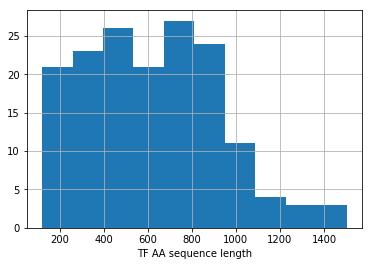

In [24]:
yeastTFs_dist_len = yeastTFs_seqs['seq'].apply(len).hist()
yeastTFs_dist_len.set_xlabel('TF AA sequence length')

if not os.path.exists(os.path.join(paths['dirResults'], 'yeastTFs_dist_len.png')) or reprocess:
    yeastTFs_dist_len.get_figure().savefig(os.path.join(paths['dirResults'], 'yeastTFs_dist_len.png'))

Create BED file of DBDs within yeast TF sequences

In [30]:
if not os.path.exists(yeastTFs_annotsDBD_file) or reprocess:
    yeastTFs_annotsDBD = yeastTFs_annotsIP.rename(
        {'Protein Accession': 'protein', 'Start Position': 'start', 'Stop Position': 'end'},
        axis='columns')
    yeastTFs_annotsDBD = yeastTFs_annotsDBD.loc[yeastTFs_annotsDBD['InterPro Entry ID'].isin(DBDs), ['protein', 'start', 'end']]
    
    yeastTFs_annotsUP_DBD = yeastTFs_annotsUP[
        (yeastTFs_annotsUP['type'] == 'DNA binding') | 
         ((yeastTFs_annotsUP['type'] == 'Region') & 
          ((yeastTFs_annotsUP['attributes'].str.find('DNA-binding') > 0) | 
           (yeastTFs_annotsUP['attributes'].str.find('DNA binding') > 0))) | 
         ((yeastTFs_annotsUP['type'] == 'Domain') & 
          (yeastTFs_annotsUP['attributes'].str.find('bZIP') > 0))]
    yeastTFs_annotsUP_DBD = yeastTFs_annotsUP_DBD.rename({'seqid': 'protein'}, axis=1)[['protein', 'start', 'end']]
    yeastTFs_annotsDBD = yeastTFs_annotsDBD.append(yeastTFs_annotsUP_DBD, ignore_index=True)
    
    yeastTFs_annotsDBD['start'] -= 1 # convert from InterPro and UniProt 1-based start to BED format 0-based start
    yeastTFs_annotsDBD.sort_values(['protein', 'start', 'end'], inplace=True)
    yeastTFs_annotsDBD.to_csv(yeastTFs_annotsDBD_file, header=False, **files.save_kwargs)
    pybedtools.BedTool(yeastTFs_annotsDBD_file).merge().saveas(yeastTFs_annotsDBD_file)
    pybedtools.helpers.cleanup(remove_all=True)

Create BED file of 9aaTADs within yeast TF sequences

In [31]:
if not os.path.exists(yeastTFs_annots9AA_file) or reprocess:
    yeastTFs_annots9AA = yeastTFs_annotsUP[yeastTFs_annotsUP['attributes'].str.find('9aaTAD') > 0]
    yeastTFs_annots9AA = yeastTFs_annots9AA.rename({'seqid': 'protein'}, axis=1)[['protein', 'start', 'end']]
    yeastTFs_annots9AA[['start']] -= 1
    yeastTFs_annots9AA.to_csv(yeastTFs_annots9AA_file, header=False, **files.save_kwargs)
    pybedtools.BedTool(yeastTFs_annots9AA_file).merge().saveas(yeastTFs_annots9AA_file)
    pybedtools.helpers.cleanup(remove_all=True)

Read in processed data

In [32]:
yeastTFs_annotsDBD = pd.read_csv(yeastTFs_annotsDBD_file, sep='\t', header=None,
                                 names=['protein', 'start', 'end'], index_col=False)
yeastTFs_annotsDBD = yeastTFs_annotsDBD[yeastTFs_annotsDBD['protein'].isin(yeastTFs)]
yeastTFs_annots9AA = pd.read_csv(yeastTFs_annots9AA_file, sep='\t', header=None,
                                 names=['protein', 'start', 'end'], index_col=False)
yeastTFs_annots9AA = yeastTFs_annots9AA[yeastTFs_annots9AA['protein'].isin(yeastTFs)]

Calculate statistics

In [34]:
print('Number of unique TFs: {}'.format(len(yeastTFs)))
print('Number of TFs with DBDs: {}'.format(yeastTFs_annotsDBD['protein'].unique().shape[0]))
print('Number of TFs with 9aaTADs: {}'.format(yeastTFs_annots9AA['protein'].unique().shape[0]))
print('Total AA length: {}'.format(yeastTFs_seqs['seq'].apply(len).sum()))
print('Total DBD length: {}'.format((yeastTFs_annotsDBD['end'] - yeastTFs_annotsDBD['start']).sum()))

Number of unique TFs: 162
Number of TFs with DBDs: 151
Number of TFs with 9aaTADs: 11
Total AA length: 101491
Total DBD length: 17814


In [39]:
print('Yeast TFs without annotated DBDs:')
print(sorted(list(set(yeastTFs) - set(yeastTFs_annotsDBD['protein'].unique()))))

Yeast TFs without annotated DBDs:
['P13393', 'P14164', 'P14908', 'P21705', 'P22149', 'P25583', 'P40522', 'P46676', 'Q03213', 'Q08957', 'Q12427']


Create tiling

In [40]:
def tile(seqLen, tileLen, overlap, priority='length-distMo'):
    '''
    Create tiling of sequence.
    
    Args
    - seqLen: int
        Length of full sequence
    - tileLen: int
        Length of each tile.
    - overlap: int
        Number of characters to overlap between tiles
    - priority: str. default='length-distMo'
        See table below.
    
    Returns: numpy.ndarray
      Each row is 0-indexed [start, end).
    
    priority         | behavior
    -------------------------------
    'length-first'   | Enforce tile length. The first 2 tiles may share greater overlap.
    'length-last'    | Enforce tile length. The last 2 tiles may share greater overlap.
    'length-distMo'  | Enforce tile length. Distribute (more) overlap; overlap will be >= the specified overlap.
    'length-distLo'  | Enforce tile length. Distribute (less) overlap; try to decrease overlap using 1 less tile.
                     |   Note that overlap may still be >= specified overlap if that is the only way for tile
                     |   length to be maintained.
    'overlap-first'  | Enforce overlap. The first tile may be shorter than `tileLen`.
    'overlap-last'   | Enforce overlap. The last tile may be shorter than `tileLen`.
    
    TODO
    'overlap-distLt' | Enforce overlap. Distribute (longer) tiles; tile length will be >= the specified tile length.
    'overlap-distSt' | Enforce overlap. Distribute (shorter) tiles; try to decrease number of tiles using 1 less
                     | overlapping region.
    check to see that code works with overlap < 0
    '''
    assert overlap < tileLen
    
    if seqLen <= tileLen:
        if seqLen < tileLen:
            warnings.warn(f'Sequence length ({seqLen}) < tile length ({tileLen})')
        return np.array([[0, seqLen]])
    
    nTiles = int(np.ceil((seqLen - tileLen) / (tileLen - overlap)) + 1)
    if priority == 'length-distLo' and (nTiles - 1) * tileLen - seqLen >= 0:
        nTiles -=1
    pos = np.zeros((nTiles, 2))
    
    if priority.startswith('length-dist'):
        avgOverlap = (nTiles * tileLen - seqLen) / (nTiles - 1)
        pos[:, 0] = np.round(np.array([i * (tileLen - avgOverlap) for i in range(nTiles)]))
    elif priority == 'length-last':
        pos[:, 0] = np.array([i * (tileLen - overlap) for i in range(nTiles)])
        pos[-1,0] = seqLen - tileLen
    elif priority == 'length-first':
        pos[:, 0] = np.array([(seqLen - tileLen) - i * (tileLen - overlap) for i in range(nTiles-1, -1, -1)])
        pos[0, 0] = 0
    pos[:, 1] = pos[:, 0] + tileLen
    
    if priority == 'overlap-last':
        pos[:, 0] = np.array([i * (tileLen - overlap) for i in range(nTiles)])
        pos[:, 1] = pos[:, 0] + tileLen
        pos[-1,1] = seqLen
    elif priority == 'overlap-first':
        pos[:, 0] = np.array([(seqLen - tileLen) - i * (tileLen - overlap) for i in range(nTiles-1, -1, -1)])
        pos[:,1] = pos[:,0] + tileLen
        pos[0, 0] = 0

    return pos

In [41]:
tileLen = 60
overlap = 15
priority = 'length-distMo'

In [42]:
tiles = []
tileNames = []
overlaps = []
for yeastTF in yeastTFs:
    pos = tile(len(yeastTFs_seqs.loc[yeastTF, 'seq']), tileLen, overlap, priority=priority)
    overlaps.append(pos[0:-1,1] - pos[1:,0])
    tiles.append(pos)
    tileNames.extend([yeastTF]*pos.shape[0])

overlaps = np.concatenate(overlaps)
tiles = pd.DataFrame(np.concatenate(tiles, axis=0), columns=['start', 'end'], dtype=int)
tiles['protein'] = tileNames
tiles = tiles[['protein', 'start', 'end']]
tiles.to_csv(yeastTFs_tiles_file, header=False, **files.save_kwargs)

for var in ['tileNames', 'pos']:
    if var in globals():
        del globals()[var]

Text(0.5, 0.98, 'Yeast TF Library Tile Length Distribution')

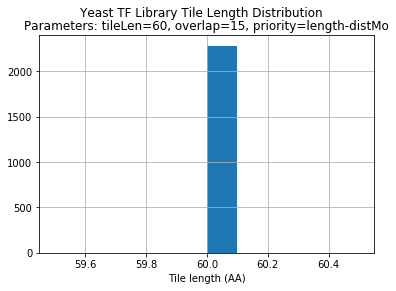

In [43]:
tileLenDist = (tiles['end'] - tiles['start']).hist()
tileLenDist.set_xlabel('Tile length (AA)')
tileLenDist.set_title(f'Parameters: tileLen={tileLen}, overlap={overlap}, priority={priority}')
tileLenDist.get_figure().suptitle('Yeast TF Library Tile Length Distribution')

Text(0.5, 0.98, 'Yeast TF Library Overlap Length Distribution')

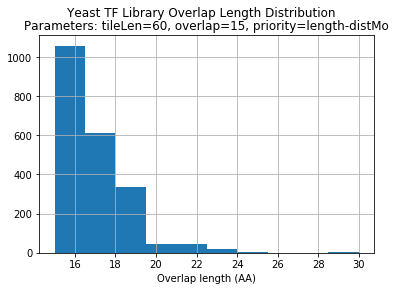

In [44]:
overlapLenDist = pd.Series(overlaps).hist()
overlapLenDist.set_xlabel('Overlap length (AA)')
overlapLenDist.set_title(f'Parameters: tileLen={tileLen}, overlap={overlap}, priority={priority}')
overlapLenDist.get_figure().suptitle('Yeast TF Library Overlap Length Distribution')

Create master annotations table

In [45]:
pybedtools.BedTool(yeastTFs_tiles_file).intersect(yeastTFs_annotsDBD_file, wao=True).saveas(yeastTFs_tilesAnnot_file)
pybedtools.BedTool(yeastTFs_tilesAnnot_file).intersect(yeastTFs_annots9AA_file, wao=True).saveas(yeastTFs_tilesAnnot_file)
pybedtools.helpers.cleanup(remove_all=True)

In [47]:
tilesAnnot = pd.read_csv(
    yeastTFs_tilesAnnot_file, sep='\t', header=None,
    names=['protein', 'start', 'end', 'drop', 'DBD_start', 'DBD_end', 'DBD_overlap', 'drop2', '9AA_start', '9AA_end', '9AA_overlap'],
    usecols=['protein', 'start', 'end', 'DBD_start', 'DBD_end', 'DBD_overlap', '9AA_start', '9AA_end', '9AA_overlap'],
    index_col=False)
tilesAnnot.to_csv(yeastTFs_tilesAnnot_file, **files.save_kwargs)

In [121]:
overlap_dist_data = np.concatenate([np.arange(31).reshape(-1,1), np.zeros((31,2))], axis=1)
tileLen_dist_data = np.copy(overlap_dist_data)
for i in range(overlap_dist_data.shape[0]):
    overlap = overlap_dist_data[i,0]
    tiles = []
    tileNames = []
    overlaps = []
    for yeastTF in yeastTFs:
        pos = tile(len(yeastTFs_seqs.loc[yeastTF, 'seq']), tileLen, overlap, priority=priority)
        overlaps.append(pos[0:-1,1] - pos[1:,0])
        tiles.append(pos)
        tileNames.extend([yeastTF]*pos.shape[0])

    tiles = pd.DataFrame(np.concatenate(tiles, axis=0), columns=['start', 'end'], dtype=int)
    tileLen_dist = tiles['end'] - tiles['start']
    tileLen_dist_data[i,1] = tileLen_dist.mean()
    tileLen_dist_data[i,2] = tileLen_dist.std()
    
    overlaps = np.concatenate(overlaps)
    overlap_dist_data[i,1] = np.mean(overlaps)
    overlap_dist_data[i,2] = np.std(overlaps)

for var in ['tileNames', 'pos']:
    if var in globals():
        del globals()[var]

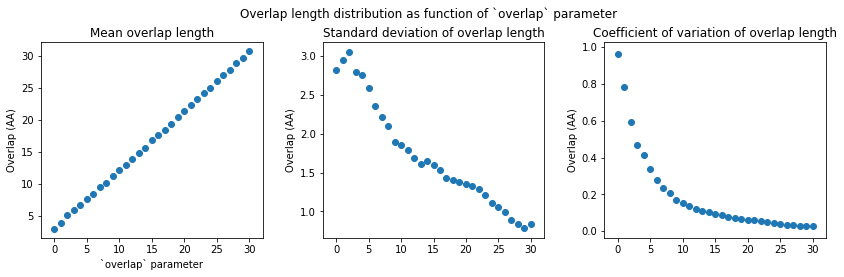

In [122]:
fig, ax = plt.subplots(1, 3, sharex=True, figsize=(12, 4))
fig.suptitle('Overlap length distribution as function of `overlap` parameter')
ax[0].scatter(overlap_dist_data[:,0], overlap_dist_data[:,1])
ax[0].set_title('Mean overlap length')
ax[0].set_ylabel('Overlap (AA)')
ax[0].set_xlabel('`overlap` parameter')
ax[1].scatter(overlap_dist_data[:,0], overlap_dist_data[:,2])
ax[1].set_title('Standard deviation of overlap length')
ax[1].set_ylabel('Overlap (AA)')
ax[2].scatter(overlap_dist_data[:,0], overlap_dist_data[:,2]/overlap_dist_data[:,1])
ax[2].set_title('Coefficient of variation of overlap length')
ax[2].set_ylabel('Overlap (AA)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

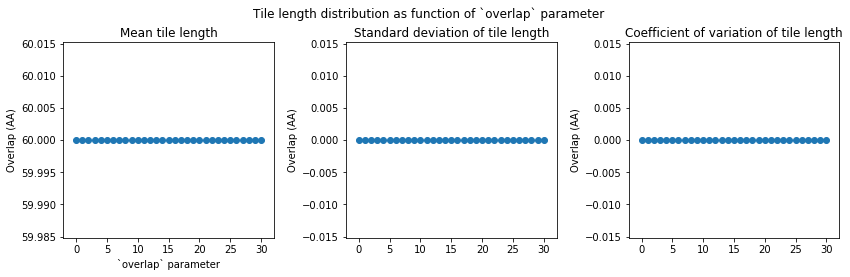

In [123]:
fig, ax = plt.subplots(1, 3, sharex=True, figsize=(12, 4))
fig.suptitle('Tile length distribution as function of `overlap` parameter')
ax[0].scatter(tileLen_dist_data[:,0], tileLen_dist_data[:,1])
ax[0].set_title('Mean tile length')
ax[0].set_ylabel('Overlap (AA)')
ax[0].set_xlabel('`overlap` parameter')
ax[1].scatter(tileLen_dist_data[:,0], tileLen_dist_data[:,2])
ax[1].set_title('Standard deviation of tile length')
ax[1].set_ylabel('Overlap (AA)')
ax[2].scatter(tileLen_dist_data[:,0], tileLen_dist_data[:,2]/tileLen_dist_data[:,1])
ax[2].set_title('Coefficient of variation of tile length')
ax[2].set_ylabel('Overlap (AA)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Human TFs

In [48]:
humanTFs_file = os.path.join(paths['dirDataGeneLists'], 'humanTFs.txt')
humanTFs_GO_file = os.path.join(paths['dirDataGeneListsRaw'], 'QuickGO_humanTFs.tsv.gz')
humanTFs_seqs_file = os.path.join(paths['dirDataProc'], 'interpro', 'humanTFs.fa.gz')
humanTFs_annotsIP_file = os.path.join(paths['dirDataProc'], 'interpro', 'humanTFs.tsv.gz')
humanTFs_annotsUP_file = os.path.join(paths['dirDataProc'], 'uniprot', 'humanTFs.tsv.gz')
humanTFs_annotsDBD_file = os.path.join(paths['dirDataAux'], 'humanTFs_DBD.bed.gz')
humanTFs_annots9AA_file = os.path.join(paths['dirDataAux'], 'humanTFs_9AA.bed.gz')
humanTFs_tiles_file = os.path.join(paths['dirDataAux'], 'humanTFs_tiles.bed.gz')
humanTFs_tilesAnnot_file = os.path.join(paths['dirDataAux'], 'humanTFs_tilesAnnot.bed.gz')

Download sequences and InterPro domains

In [51]:
if not os.path.exists(humanTFs_file) or reprocess:
    humanTFs_GO = downloadBio.get_QuickGO_annotations(['GO:0003700'], taxonId=9606)
    humanTFs_GO.to_csv(humanTFs_GO_file, **files.save_kwargs)
    humanTFs = humanTFs_GO['GENE PRODUCT ID'].unique().tolist()
else:
    humanTFs = utils_files.readFile(humanTFs_file)

In [52]:
humanTFs = [humanTF.split('-')[0] for humanTF in humanTFs]
humanTFs = [humanTF.split(':')[0] for humanTF in humanTFs]
humanTFs = set(humanTFs)

In [53]:
if reprocess:
    if os.path.exists(humanTFs_seqs_file): os.remove(humanTFs_seqs_file)
    if os.path.exists(humanTFs_annotsIP_file): os.remove(humanTFs_annotsIP_file)
    if os.path.exists(humanTFs_annotsUP_file): os.remove(humanTFs_annotsUP_file)
if not (os.path.exists(humanTFs_seqs_file) and 
        os.path.exists(humanTFs_annotsIP_file) and 
        os.path.exists(humanTFs_annotsUP_file)):
    results_seqs = []
    results_annotsIP = []
    results_annotsUP = []
    with Pool(processes=nProc) as pool:
        for humanTF in humanTFs:
            print(f'Downloading InterPro FASTA sequence, InterPro annotation table, and UniProt annotation table for {humanTF}.')
            if nProc > 1:
                results_seqs.append(pool.apply_async(downloadBio.get_InterPro_protein,
                                                     (humanTF,), {'export': 'fasta', 'toDf': False}))
                results_annotsIP.append(pool.apply_async(downloadBio.get_InterPro_protein,
                                                                (humanTF,), {'export': 'tsv'}))
                results_annotsUP.append(pool.apply_async(downloadBio.get_UniProt,
                                                               (humanTF, 'gff')))
            else:
                results_seqs.append(downloadBio.get_InterPro_protein(humanTF, export='fasta', toDf=False) + '\n')
                results_annotsIP.append(downloadBio.get_InterPro_protein(humanTF, export='tsv'))
                results_annotsUP.append(downloadBio.get_UniProt(humanTF, export='gff'))

        if nProc > 1:
            results_seqs = [result.get() + '\n' for result in results_seqs]
            results_annotsIP = [result.get() for result in results_annotsIP]
            results_annotsUP = [result.get() for result in results_annotsUP]
    
    seqs = ''.join(results_seqs)
    with gzip.open(humanTFs_seqs_file, 'at') as f:
        f.write(seqs)
    humanTFs_seqs = utils_bio.fastaToDF(io.StringIO(seqs), headerParser=utils_bio.parseDefaultHeader)
    humanTFs_seqs.set_index('name', inplace=True)

    humanTFs_annotsIP = pd.concat(results_annotsIP, ignore_index=True)
    humanTFs_annotsIP.to_csv(humanTFs_annotsIP_file, **files.save_kwargs)
    
    humanTFs_annotsUP = pd.concat(results_annotsUP, ignore_index=True)
    humanTFs_annotsUP.to_csv(humanTFs_annotsUP_file, **files.save_kwargs)
else:
    humanTFs_seqs = utils_bio.fastaToDF(humanTFs_seqs_file, headerParser=utils_bio.parseDefaultHeader)
    humanTFs_seqs.set_index('name', inplace=True)
    humanTFs_annotsIP = pd.read_csv(humanTFs_annotsIP_file, sep='\t', header=0, index_col=False)
    humanTFs_annotsUP = pd.read_csv(humanTFs_annotsUP_file, sep='\t', header=0, index_col=False)

for var in ['results_seqs', 'results_annotsIP', 'results_annotsUP', 'seqs']:
    if var in globals():
        del globals()[var]

Remove duplicate sequences

In [54]:
if reprocess:
    display(humanTFs_seqs[humanTFs_seqs.duplicated('seq', keep=False)])
    dups = humanTFs_seqs.index[humanTFs_seqs.duplicated('seq')].tolist()
    print('Removing {} from human TF list.'.format(', '.join(dups)))
    humanTFs_seqs.drop_duplicates('seq', inplace=True)
    humanTFs = humanTFs_seqs.index.tolist()
    with open(humanTFs_file, 'w') as f:
        f.write('\n'.join(humanTFs))

Plot distribution of sequence lengths

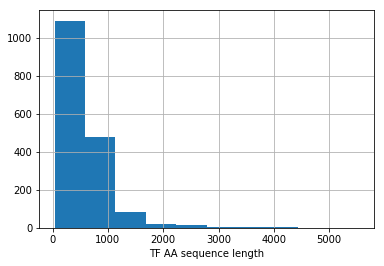

In [55]:
humanTFs_dist_len = humanTFs_seqs['seq'].apply(len).hist()
humanTFs_dist_len.set_xlabel('TF AA sequence length')

if not os.path.exists(os.path.join(paths['dirResults'], 'humanTFs_dist_len.png')) or reprocess:
    humanTFs_dist_len.get_figure().savefig(os.path.join(paths['dirResults'], 'humanTFs_dist_len.png'))

Create BED file of DBDs within human TF sequences

In [56]:
if not os.path.exists(humanTFs_annotsDBD_file) or reprocess:
    humanTFs_annotsDBD = humanTFs_annotsIP.rename(
        {'Protein Accession': 'protein', 'Start Position': 'start', 'Stop Position': 'end'},
        axis='columns')
    humanTFs_annotsDBD = humanTFs_annotsDBD.loc[humanTFs_annotsDBD['InterPro Entry ID'].isin(DBDs), ['protein', 'start', 'end']]
    
    humanTFs_annotsUP_DBD = humanTFs_annotsUP[
        (humanTFs_annotsUP['type'] == 'DNA binding') | 
         ((humanTFs_annotsUP['type'] == 'Region') & 
          ((humanTFs_annotsUP['attributes'].str.find('DNA-binding') > 0) | 
           (humanTFs_annotsUP['attributes'].str.find('DNA binding') > 0))) | 
         ((humanTFs_annotsUP['type'] == 'Domain') & 
          (humanTFs_annotsUP['attributes'].str.find('bZIP') > 0))]
    humanTFs_annotsUP_DBD = humanTFs_annotsUP_DBD.rename({'seqid': 'protein'}, axis=1)[['protein', 'start', 'end']]
    humanTFs_annotsDBD = humanTFs_annotsDBD.append(humanTFs_annotsUP_DBD, ignore_index=True)
    
    humanTFs_annotsDBD['start'] -= 1 # convert from InterPro and UniProt 1-based start to BED format 0-based start
    humanTFs_annotsDBD.sort_values(['protein', 'start', 'end'], inplace=True)
    humanTFs_annotsDBD.to_csv(humanTFs_annotsDBD_file, sep='\t', header=False, index=False)
    pybedtools.BedTool(humanTFs_annotsDBD_file).merge().saveas(humanTFs_annotsDBD_file)
    pybedtools.helpers.cleanup(remove_all=True)

Create BED file of 9aaTADs within yeast TF sequences

In [57]:
if not os.path.exists(humanTFs_annots9AA_file) or reprocess:
    humanTFs_annots9AA = humanTFs_annotsUP[humanTFs_annotsUP['attributes'].str.find('9aaTAD') > 0]
    humanTFs_annots9AA = humanTFs_annots9AA.rename({'seqid': 'protein'}, axis=1)[['protein', 'start', 'end']]
    humanTFs_annots9AA[['start']] -= 1
    humanTFs_annots9AA.to_csv(humanTFs_annots9AA_file, header=False, **files.save_kwargs)
    pybedtools.BedTool(humanTFs_annots9AA_file).merge().saveas(humanTFs_annots9AA_file)
    pybedtools.helpers.cleanup(remove_all=True)

Read in processed data

In [58]:
humanTFs_annotsDBD = pd.read_csv(humanTFs_annotsDBD_file, sep='\t', header=None,
                                 names=['protein', 'start', 'end'], index_col=False)
humanTFs_annotsDBD = humanTFs_annotsDBD[humanTFs_annotsDBD['protein'].isin(humanTFs)]
humanTFs_annots9AA = pd.read_csv(humanTFs_annots9AA_file, sep='\t', header=None,
                                 names=['protein', 'start', 'end'], index_col=False)
humanTFs_annots9AA = humanTFs_annots9AA[humanTFs_annots9AA['protein'].isin(humanTFs)]

Calculate statistics

In [59]:
print('Number of unique TFs: {}'.format(len(humanTFs)))
print('Number of TFs with DBDs: {}'.format(humanTFs_annotsDBD['protein'].unique().shape[0]))
print('Number of TFs with 9aaTADs: {}'.format(humanTFs_annots9AA['protein'].unique().shape[0]))
print('Total AA length: {}'.format(humanTFs_seqs['seq'].apply(len).sum()))
print('Total DBD length: {}'.format((humanTFs_annotsDBD['end'] - humanTFs_annotsDBD['start']).sum()))

Number of unique TFs: 1695
Number of TFs with DBDs: 1557
Number of TFs with 9aaTADs: 10
Total AA length: 1011584
Total DBD length: 444327


In [60]:
print('Human TFs without annotated DBDs:')
print(sorted(list(set(humanTFs) - set(humanTFs_annotsDBD['protein'].unique()))))

Human TFs without annotated DBDs:
['O00287', 'O14593', 'O14686', 'O14981', 'O15162', 'O43151', 'O43189', 'O43593', 'O60260', 'O60284', 'O60861', 'O60925', 'O75716', 'O95218', 'O95619', 'O95997', 'P01270', 'P06400', 'P06733', 'P0CG35', 'P20749', 'P25791', 'P35222', 'P35227', 'P35232', 'P36894', 'P40879', 'P41221', 'P42568', 'P42681', 'P46100', 'P46531', 'P47974', 'P49848', 'P51610', 'P51816', 'P51825', 'P51826', 'P54198', 'P61129', 'P61968', 'P63272', 'P78543', 'Q01538', 'Q01658', 'Q03111', 'Q03701', 'Q04727', 'Q06547', 'Q07352', 'Q09472', 'Q13033', 'Q13363', 'Q13487', 'Q13547', 'Q13951', 'Q14134', 'Q14202', 'Q14602', 'Q14919', 'Q14978', 'Q15170', 'Q15542', 'Q15543', 'Q15545', 'Q15910', 'Q16514', 'Q16666', 'Q17RH7', 'Q2TAL8', 'Q32MQ0', 'Q3KNV8', 'Q5SVZ6', 'Q5T6S3', 'Q5VZL5', 'Q6ZN28', 'Q7RTV0', 'Q7Z5J4', 'Q7Z5L9', 'Q86SE9', 'Q86UQ8', 'Q86X95', 'Q8IU81', 'Q8IUM7', 'Q8IWS0', 'Q8IXQ3', 'Q8IXZ2', 'Q8IZQ8', 'Q8N187', 'Q8N5P1', 'Q8N653', 'Q8WVM7', 'Q8WWB7', 'Q8WYN3', 'Q92800', 'Q96CJ1', 'Q96E

Create tiling

In [114]:
tileLen = 60
overlap = 15
priority = 'length-distMo'

In [63]:
tiles = []
tileNames = []
overlaps = []
for humanTF in humanTFs:
    pos = tile(len(humanTFs_seqs.loc[humanTF, 'seq']), tileLen, overlap, priority=priority)
    overlaps.append(pos[0:-1,1] - pos[1:,0])
    tiles.append(pos)
    tileNames.extend([humanTF]*pos.shape[0])

overlaps = np.concatenate(overlaps)
tiles = pd.DataFrame(np.concatenate(tiles, axis=0), columns=['start', 'end'], dtype=int)
tiles['protein'] = tileNames
tiles = tiles[['protein', 'start', 'end']]
tiles.to_csv(humanTFs_tiles_file, header=False, **files.save_kwargs)

for var in ['tileNames', 'pos']:
    if var in globals():
        del globals()[var]

/home/users/bentyeh/miniconda3/envs/rpy3_tmp/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Sequence length (36) < tile length (60)
/home/users/bentyeh/miniconda3/envs/rpy3_tmp/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Sequence length (45) < tile length (60)


Text(0.5, 0.98, 'Human TF Library Tile Length Distribution')

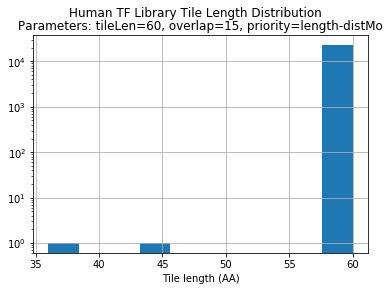

In [64]:
tileLenDist = (tiles['end'] - tiles['start']).hist(log=True)
tileLenDist.set_xlabel('Tile length (AA)')
tileLenDist.set_title(f'Parameters: tileLen={tileLen}, overlap={overlap}, priority={priority}')
tileLenDist.get_figure().suptitle('Human TF Library Tile Length Distribution')

Text(0.5, 0.98, 'Human TF Library Overlap Length Distribution')

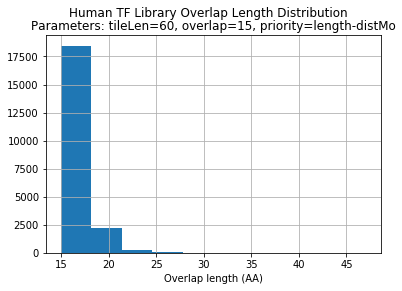

In [80]:
overlapLenDist = pd.Series(overlaps).hist()
overlapLenDist.set_xlabel('Overlap length (AA)')
overlapLenDist.set_title(f'Parameters: tileLen={tileLen}, overlap={overlap}, priority={priority}')
overlapLenDist.get_figure().suptitle('Human TF Library Overlap Length Distribution')

Create master annotations table

In [66]:
pybedtools.BedTool(humanTFs_tiles_file).intersect(humanTFs_annotsDBD_file, wao=True).saveas(humanTFs_tilesAnnot_file)
pybedtools.BedTool(humanTFs_tilesAnnot_file).intersect(humanTFs_annots9AA_file, wao=True).saveas(humanTFs_tilesAnnot_file)
pybedtools.helpers.cleanup(remove_all=True)

In [67]:
tilesAnnot = pd.read_csv(
    humanTFs_tilesAnnot_file, sep='\t', header=None,
    names=['protein', 'start', 'end', 'drop', 'DBD_start', 'DBD_end', 'DBD_overlap', 'drop2', '9AA_start', '9AA_end', '9AA_overlap'],
    usecols=['protein', 'start', 'end', 'DBD_start', 'DBD_end', 'DBD_overlap', '9AA_start', '9AA_end', '9AA_overlap'],
    index_col=False)
tilesAnnot.to_csv(humanTFs_tilesAnnot_file, **files.save_kwargs)

In [118]:
overlap_dist_data = np.concatenate([np.arange(31).reshape(-1,1), np.zeros((31,2))], axis=1)
tileLen_dist_data = np.copy(overlap_dist_data)
for i in range(overlap_dist_data.shape[0]):
    overlap = overlap_dist_data[i,0]
    tiles = []
    tileNames = []
    overlaps = []
    for humanTF in humanTFs:
        pos = tile(len(humanTFs_seqs.loc[humanTF, 'seq']), tileLen, overlap, priority=priority)
        overlaps.append(pos[0:-1,1] - pos[1:,0])
        tiles.append(pos)
        tileNames.extend([humanTF]*pos.shape[0])

    tiles = pd.DataFrame(np.concatenate(tiles, axis=0), columns=['start', 'end'], dtype=int)
    tileLen_dist = tiles['end'] - tiles['start']
    tileLen_dist_data[i,1] = tileLen_dist.mean()
    tileLen_dist_data[i,2] = tileLen_dist.std()
    
    overlaps = np.concatenate(overlaps)
    overlap_dist_data[i,1] = np.mean(overlaps)
    overlap_dist_data[i,2] = np.std(overlaps)

for var in ['tileNames', 'pos']:
    if var in globals():
        del globals()[var]

/home/users/bentyeh/miniconda3/envs/rpy3_tmp/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Sequence length (36) < tile length (60)
/home/users/bentyeh/miniconda3/envs/rpy3_tmp/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Sequence length (45) < tile length (60)


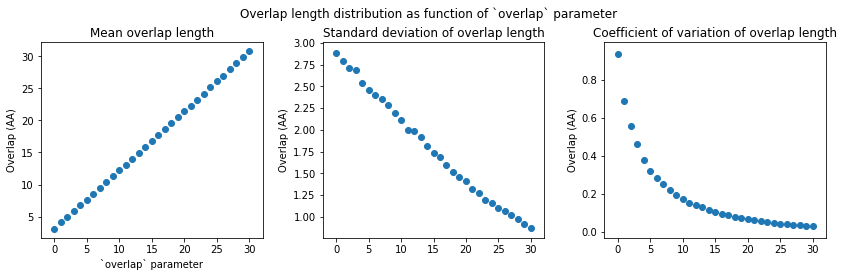

In [119]:
fig, ax = plt.subplots(1, 3, sharex=True, figsize=(12, 4))
fig.suptitle('Overlap length distribution as function of `overlap` parameter')
ax[0].scatter(overlap_dist_data[:,0], overlap_dist_data[:,1])
ax[0].set_title('Mean overlap length')
ax[0].set_ylabel('Overlap (AA)')
ax[0].set_xlabel('`overlap` parameter')
ax[1].scatter(overlap_dist_data[:,0], overlap_dist_data[:,2])
ax[1].set_title('Standard deviation of overlap length')
ax[1].set_ylabel('Overlap (AA)')
ax[2].scatter(overlap_dist_data[:,0], overlap_dist_data[:,2]/overlap_dist_data[:,1])
ax[2].set_title('Coefficient of variation of overlap length')
ax[2].set_ylabel('Overlap (AA)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

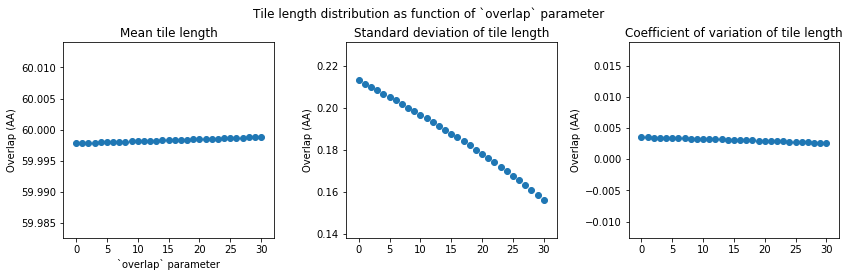

In [120]:
fig, ax = plt.subplots(1, 3, sharex=True, figsize=(12, 4))
fig.suptitle('Tile length distribution as function of `overlap` parameter')
ax[0].scatter(tileLen_dist_data[:,0], tileLen_dist_data[:,1])
ax[0].set_title('Mean tile length')
ax[0].set_ylabel('Overlap (AA)')
ax[0].set_xlabel('`overlap` parameter')
ax[1].scatter(tileLen_dist_data[:,0], tileLen_dist_data[:,2])
ax[1].set_title('Standard deviation of tile length')
ax[1].set_ylabel('Overlap (AA)')
ax[2].scatter(tileLen_dist_data[:,0], tileLen_dist_data[:,2]/tileLen_dist_data[:,1])
ax[2].set_title('Coefficient of variation of tile length')
ax[2].set_ylabel('Overlap (AA)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Appendix

## Data sources

### InterPro

Instead of downloading InterPro tables for each protein of interest, we could use InterProScan to scan sequences for matches to designated InterPro entries. See https://github.com/ebi-pf-team/interproscan/wiki/HowToRun.

### Prosite

GO-term mapping: https://prosite.expasy.org/cgi-bin/unirule/unirule_browse.cgi?context=PROSITE&browse=go

## Validation

Manually check InterPro entries selected by keywords for false positives (e.g., terms containing "DNA-binding" in its description that do not actually describe a DNA-binding domain")

In [69]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', 100):
    display(interpro_filteredKeyword[~interpro_filteredKeyword['ENTRY_AC'].isin(interpro_filteredGO['InterPro_ID'])])

,ENTRY_AC,ENTRY_TYPE,ENTRY_NAME
1728,IPR003163,Domain,"Transcription regulator HTH, APSES-type DNA-binding domain"
2051,IPR004330,Domain,FAR1 DNA binding domain
2525,IPR006600,Domain,HTH CenpB-type DNA-binding domain
2861,IPR007634,Domain,"RNA polymerase sigma factor 54, DNA-binding"
3444,IPR010896,Domain,Nuclease-associated modular DNA-binding 1
3842,IPR012909,Domain,"PHA accumulation regulator DNA-binding, N-terminal"
4619,IPR015126,Domain,"Mu DNA binding, I gamma subdomain"
4786,IPR015358,Domain,"Transcription regulator MerR, DNA binding"
4794,IPR015367,Domain,"Transcription factor CEP-1, DNA-binding domain"
4798,IPR015371,Domain,"Endonuclease VIII-like 1, DNA binding"


Compare InterPro entries found via keywords versus GO terms

In [ ]:
# InterPro entries found only via keywords
interpro_filteredKeyword[~interpro_filteredKeyword['ENTRY_AC'].isin(interpro_filteredGO['InterPro_ID'])]

# InterPro entries found only via GO terms
interpro_filteredGO[~interpro_filteredGO['InterPro_ID'].isin(interpro_filteredKeyword['ENTRY_AC'])]

# InterPro entries found both via keywords and GO terms
interpro_filteredKeyword[interpro_filteredKeyword['ENTRY_AC'].isin(interpro_filteredGO['InterPro_ID'])]

# Check for false-positives in keyword-filtered InterPro entries
display(interpro_filteredKeyword[interpro_filteredKeyword['ENTRY_NAME'].str.find('regulation') > 0])
display(interpro_filteredKeyword[interpro_filteredKeyword['ENTRY_NAME'].str.find('repression') > 0])

Verify that all human transcription factors found via GO code are part of SwissProt

In [ ]:
uniprotProteome = pd.read_csv(paths['uniprotProteome'], sep='\t', index_col=False)
swissprotProteome = uniprotProteome.loc[uniprotProteome['db'] == 'sp', 'id'].tolist()
all([tf in swissprotProteome for tf in humanTFs])

## Extra code

Extract sequences based on BED-like table

In [ ]:
tiles['seq'] = [yeastTFs_seqs.loc[row['protein'], 'seq'][row['start']:row['end']] for _, row in tiles.iterrows()]
tiles = tiles[['protein', 'start', 'end', 'seq']]

### Old code

In [ ]:
for yeastTF in yeastTFs:
    yeastTF_seqFile = os.path.join(paths['dirDataRaw'], 'interpro', 'proteins', yeastTF + '.tsv.gz')
    yeastTF_annotFile = os.path.join(paths['dirDataRaw'], 'interpro', 'proteins', yeastTF + '.fa.gz')
    if not (os.path.exists(tf_info_file) and os.path.exists(tf_seq_file)):
        print(f'Downloading InterPro FASTA sequence and annotation table for {yeastTF}.')
        seq = downloadBio.get_InterPro_protein(yeastTF, export='fasta')
        with gzip.open(tf_seq_file, 'wt') as f:
            f.write(seq)
        annot = downloadBio.get_InterPro_protein(yeastTF, export='tsv')
        annot.to_csv(yeastTF_seqFile, sep='\t', index=False)         

In [ ]:
for yeastTF in yeastTFs:
    yeastTF_annotFile = os.path.join(paths['dirDataRaw'], 'interpro', 'proteins', yeastTF + '.tsv.gz')
    yeastTF_bedFile = os.path.join(paths['dirDataAux'], 'yeastTFs_BED', yeastTF + '.bed.gz')

    if reprocess or not os.path.exists(yeastTF_bedFile):
        df = pd.read_csv(yeastTF_annotFile, sep='\t', header=0, index_col=False) \
               .rename({'Protein Accession': 'protein', 'Start Position': 'start', 'Stop Position': 'end'}, axis='columns')
        df = df.loc[df['InterPro Entry ID'].isin(DBDs), ['protein', 'start', 'end']]
        df['start'] -= 1
        df.sort_values(['protein', 'start', 'end'], inplace=True)
        df.to_csv(yeastTF_bedFile, sep='\t', header=False, index=False)
        pybedtools.BedTool(yeastTF_bedFile).merge().saveas(yeastTFs_annotDBDFile)

In [ ]:
def tileSeq(seq, length, overlap, bed):
    # assert ((bed['start'] >= 0).all() and (bed['end'] <= len(seq)).all())
    if len(seq) < 10:
        warnings.warn('Total sequence length < 10 AA.')
    
    #tiles = pd.DataFrame(columns=['protein', 'start', 'end', 'seq', 'percentIsDBD', 'percentOfDBD'])
    tiles = []
    seqLen = len(seq)
    start = 0
    
    if seqLen < length:
        tile = seq
        end = seqLen
        percentIsDBD, DBDs_overlapped = DBD_overlap(start, end, bed)
        tiles.append((start, end, seq, percentIsDBD, DBDs_overlapped))
    else:
        end = start + length
        while end < seqLen:
            percentIsDBD, DBDs_overlapped = DBD_overlap(start, end, bed)
            tiles.append((start, end, seq[start:end], percentIsDBD, DBDs_overlapped))
            start = start + length - overlap
            end = end + length - overlap
        percentIsDBD, DBDs_overlapped = DBD_overlap(start, end, bed)
        tiles.append((start, seqLen, seq[start:], percentIsDBD, DBDs_overlapped))
    
    tiles = pd.DataFrame(tiles, columns=['start', 'end', 'seq', 'percentIsDBD', 'DBDs_overlapped'])
    return tiles

In [ ]:
def DBD_overlap(start, end, bed=None):
    if bed is None:
        return (0, '')
    DBDs_overlapped = []
    lengthIsDBD = 0
    for _, row in bed.iterrows():
        if (start <= row['start']) and (end > row['start']):
            if (end >= row['end']):
                # region entirely wraps DBD
                DBDs_overlapped.append('1')
            else:
                # region extends into DBD
                DBDs_overlapped.append('{:.2f}'.format((end-row['start'])/(row['end']-row['start'])))
                lengthIsDBD += end - row['start']
        elif (start > row['start']) and (start < row['end']):
            if (end <= row['end']):
                # region entirely within DBD
                DBDs_overlapped.append('{:.2f}'.format((end-start)/(row['end']-row['start'])))
                lengthIsDBD += end - start
            else:
                # region extends beyond DBD
                DBDs_overlapped.append('{:.2f}'.format((row['end'] - start)/(row['end']-row['start'])))
                lengthIsDBD += row['end'] - start
            
    percentIsDBD = lengthIsDBD / (end-start)
    DBDs_overlapped = ','.join(DBDs_overlapped)
    return (percentIsDBD, DBDs_overlapped)